In [1]:
import torch

In [2]:
import torchvision

In [22]:
import torchvision.transforms as transforms

In [119]:
import matplotlib.pyplot as plt

In [77]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [78]:
from torch.distributions.normal import Normal

In [159]:
trans = transforms.Compose([transforms.ToTensor()])

In [160]:
train_set = torchvision.datasets.MNIST("./MNIST", train=True, transform=trans)
test_set = torchvision.datasets.MNIST("./MNIST", train=False, transform=trans)

In [76]:
train_set[0][0].shape

torch.Size([1, 28, 28])

In [277]:
class VAE(torch.nn.Module):
    def __init__(self, device, dim_z):
        super(VAE, self).__init__()
        
        self.device = device
        self.dim_z = dim_z
        
        ### Encoder
        self.conv1 = nn.Conv2d(in_channels=1 , out_channels=32,
                              kernel_size = 4, stride = 2, padding=1).to(device)
        self.conv2 = nn.Conv2d(in_channels=32 , out_channels=64,
                              kernel_size = 4, stride = 2, padding=1).to(device)
        self.conv3 = nn.Conv2d(in_channels=64 , out_channels=128,
                              kernel_size = 5, stride = 2, padding=2).to(device)
        
        self.mu = nn.Linear(128 * 16, dim_z).to(device)
        self.log_std =nn.Linear(128 * 16, dim_z).to(device)
        
        self.recons = nn.Linear(dim_z, 256).to(device)
        
        
        ### Decoder
        self.t_conv1 = nn.ConvTranspose2d(in_channels=256, out_channels= 128,
                                          kernel_size= 4, stride= 1, padding=0).to(device) #[4,4]
        self.t_conv2 = nn.ConvTranspose2d(in_channels=128, out_channels= 64,
                                          kernel_size= 5, stride= 2, padding=2).to(device) #[7,7]
        self.t_conv3 = nn.ConvTranspose2d(in_channels=64, out_channels= 32,
                                          kernel_size= 4, stride= 2, padding=1).to(device) #[14,14]
        self.t_conv4 = nn.ConvTranspose2d(in_channels=32, out_channels= 1,
                                          kernel_size= 4, stride= 2, padding=1).to(device) #[28,28]
        
        self.optimizer = optim.Adam(self.parameters(), lr=1e-3)
    
    
    
    def encode(self, x):
        assert len(x.shape) == 4 #[batch, channel, height, width]
        
        x = F.celu(self.conv1(x))
        x = F.celu(self.conv2(x))
        x = F.celu(self.conv3(x))
        
        x = x.view(-1, 128 * 16)
        
        mu = self.mu(x)
        sigma = torch.exp(self.log_std(x))
        
        return mu, sigma #[batch, 16]
    
    
    def reparameterization(self, mu, sigma):
        temp_normal = Normal(mu,sigma)
        
        return temp_normal.rsample() #[batch, 16]
    
    def decode(self, z):
        
        x = F.celu(self.recons(z)) #[batch, 256]
        
        x = x.view(-1,256,1,1)
        
        x = F.celu(self.t_conv1(x))
        x = F.celu(self.t_conv2(x))
        x = F.celu(self.t_conv3(x))
        x = torch.sigmoid(self.t_conv4(x))
        
        return x
    
    
    def train(self, batch):
        assert len(batch.shape) == 4
        
        mus, sigmas = self.encode(batch)
        zs = self.reparameterization(mus, sigmas)
        
        recons = self.decode(zs)
        
        reconstruction_error = F.binary_cross_entropy(recons, batch, reduction="sum") / batch.shape[0]
        
        var = sigmas ** 2
        mu_2 = mus ** 2
        
        regularization_error = torch.mean(torch.sum(-0.5 * (1 + torch.log(var) - mu_2 - var), dim=1, keepdim=False))
        
        loss = reconstruction_error + regularization_error
        
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_value_(self.parameters(), 1.0)
        self.optimizer.step()
        
        return reconstruction_error.detach().cpu().numpy(), regularization_error.detach().cpu().numpy(), loss.detach().cpu().numpy()
        
    
    def evaluate(self):
        pass
        

In [157]:
t_image = train_set[0][0].view(1,1,28,28)

In [110]:
m_vae = VAE(torch.device("cpu"))

In [111]:
tmu, tsigma = m_vae.encode(t_image)

In [112]:
tz = m_vae.reparameterization(tmu, tsigma)

In [113]:
trc = m_vae.decode(tz)

In [118]:
tm = trc.detach().numpy()

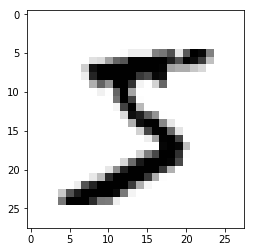

In [153]:
plt.imshow(t_image[0][0], cmap=plt.cm.binary)

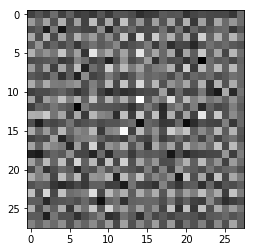

In [125]:
plt.imshow(tm[0][0], cmap=plt.cm.binary)

In [79]:
a = Normal(torch.rand([100,16]),torch.rand([100,16]))

In [89]:
t = a.rsample()

In [91]:
t

tensor([[ 0.7002,  0.9852, -0.0196,  ..., -0.0576,  0.7174,  1.4704],
        [ 0.7381,  0.5443,  1.8972,  ...,  0.2595,  0.7786,  1.7380],
        [ 0.4614,  0.7422,  1.0623,  ...,  0.9102,  0.0301,  0.3045],
        ...,
        [ 0.2295,  0.3426,  1.0906,  ..., -0.1126,  0.7538,  1.2382],
        [ 0.4956,  1.4419,  0.5738,  ...,  0.8923, -0.2431,  1.1706],
        [ 0.8660,  0.4542,  0.8943,  ..., -0.2819,  1.9126, -0.5307]])

In [52]:
len(train_set), len(test_set)

(60000, 10000)

In [162]:
train_loader = torch.utils.data.DataLoader(train_set,batch_size=100,shuffle=True)
test_loader = torch.utils.data.DataLoader(train_set,batch_size=1,shuffle=False)

In [62]:
count = 0

In [145]:
k = list(enumerate(train_loader))

In [130]:
len(k)

600

In [147]:
k[0][1][0].shape , k[0][1][1].shape

(torch.Size([100, 1, 28, 28]), torch.Size([100]))

In [146]:
torch.max(k[0][1][0][0])

tensor(1.)

In [71]:

for i in train_loader:
    count +=1
print(count)

602


In [69]:
i[0].shape

torch.Size([100, 1, 28, 28])

In [68]:
i[1].shape

torch.Size([100])

In [262]:
device = torch.device("cuda")
dim_z = 2

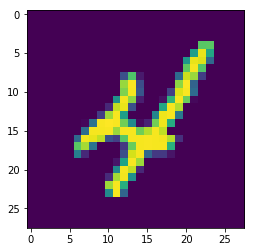

In [232]:
plt.imshow(train_set[9][0][0].to(device).cpu().numpy())

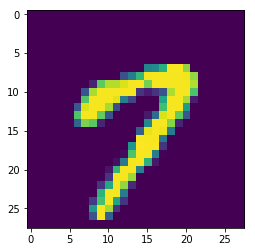

In [255]:
plt.imshow(train_set[15][0][0].to(device).cpu().numpy())

In [258]:
t1 = train_set[9][0].to(device)
t2 = train_set[10][0].to(device)

In [280]:
m1, s1 = m_vae.encode(t1.view(1,1,28,28))
z1 = m_vae.reparameterization(m1,s1)

m2, s2 = m_vae.encode(t2.view(1,1,28,28))
z2 = m_vae.reparameterization(m2,s2)

r1 = m_vae.decode(z1)
r2 = m_vae.decode(z2)

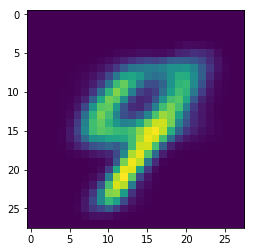

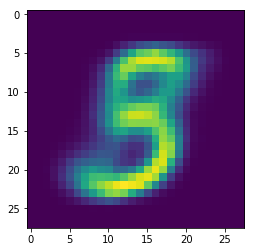

In [281]:
plt.imshow(r1[0][0].detach().cpu().numpy())
plt.show()
plt.imshow(r2[0][0].detach().cpu().numpy())
plt.show()


In [316]:
i = np.arange(21)/2 - 5.0
j = np.arange(21)/2 - 5.0

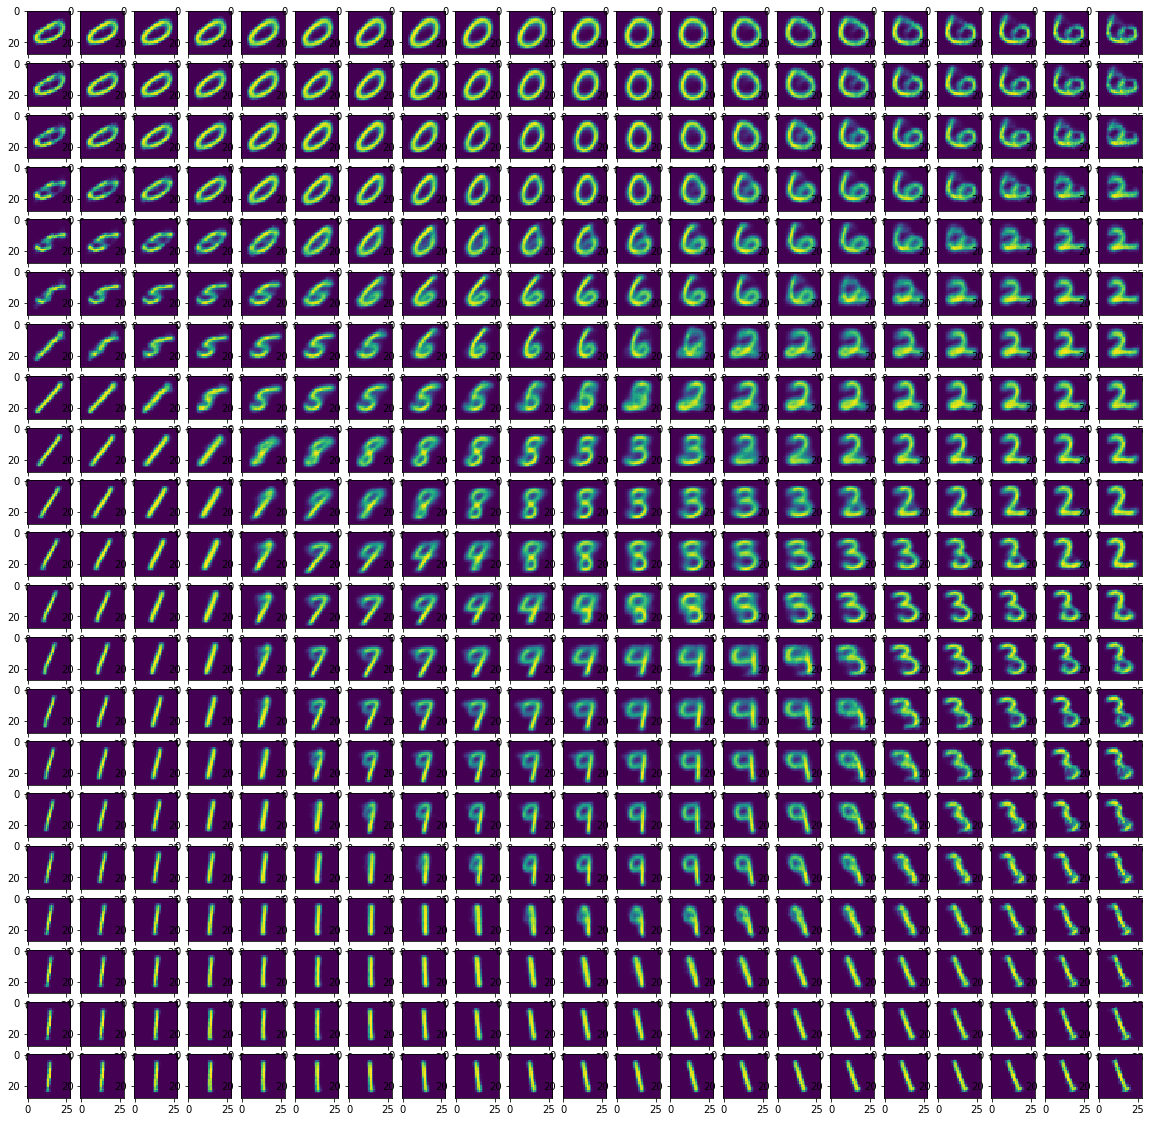

In [337]:
w=10
h=10
fig=plt.figure(figsize=(20, 20))
columns = 21
rows = 21
count = 1
for idx, ii in enumerate(i):
    for jdx, jj in enumerate(j):
        z = torch.FloatTensor([[ii,jj]]).to(device)
        r = m_vae.decode(z)
        fig.add_subplot(rows,columns, count)
        count +=1
        plt.imshow(r[0][0].detach().cpu().numpy())
plt.savefig("latent_walking.png", dpi=100)
plt.show()

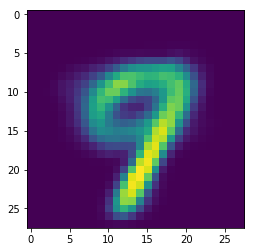

In [290]:
z = torch.FloatTensor([[1.0,-1.0]]).to(device)
r = m_vae.decode(z)
plt.imshow(r[0][0].detach().cpu().numpy())
plt.show()

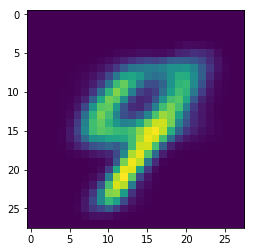

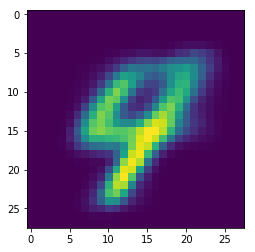

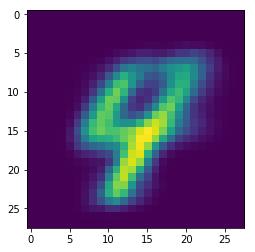

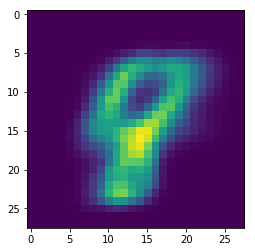

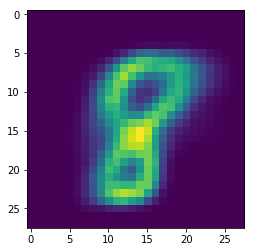

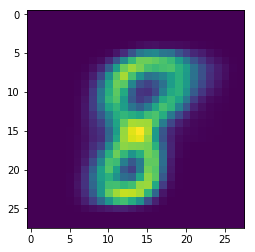

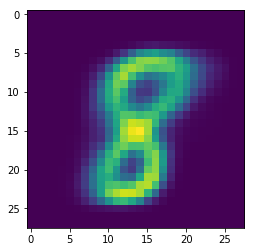

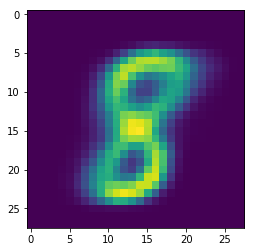

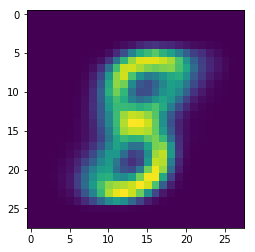

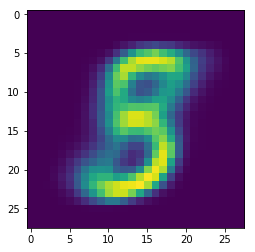

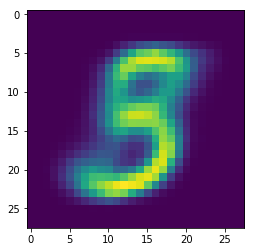

In [284]:
for i in range(11):
    z = z1 * (1 - 0.1 * i) + z2 * i * 0.1
    r = m_vae.decode(z)
    plt.imshow(r[0][0].detach().cpu().numpy())
    plt.show()

In [278]:
m_vae = VAE(device, dim_z)

epoch finished :  0
158.36618 5.2586203 163.6248


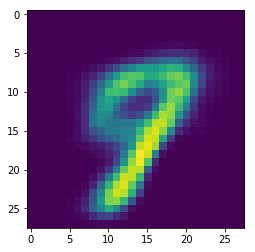

epoch finished :  1
155.61815 5.689371 161.30753


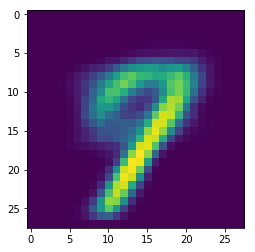

epoch finished :  2
150.13658 5.9639697 156.10056


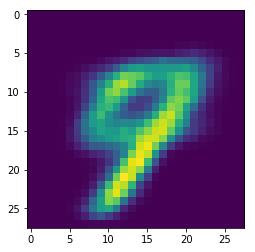

epoch finished :  3
147.65298 6.1805015 153.83348


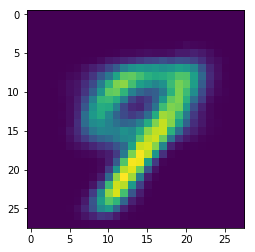

epoch finished :  4
142.32967 6.79648 149.12614


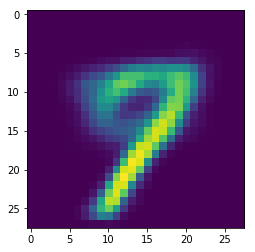

epoch finished :  5
141.74341 6.071129 147.81454


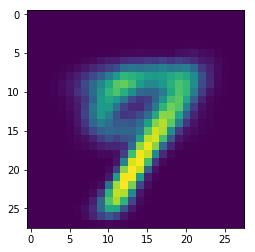

epoch finished :  6
149.34906 6.8216224 156.17068


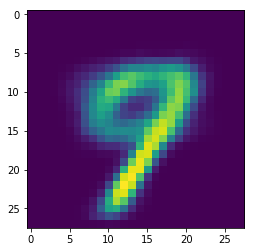

epoch finished :  7
147.86131 7.1639123 155.02522


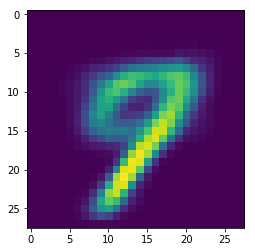

epoch finished :  8
134.87906 7.710749 142.58981


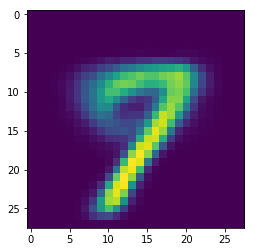

epoch finished :  9
147.05203 6.810031 153.86206


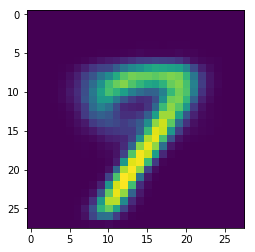

epoch finished :  10
148.3289 7.7040434 156.03294


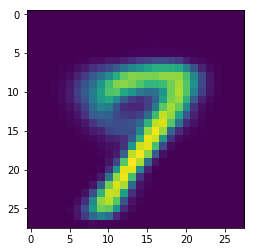

epoch finished :  11
142.00488 7.737478 149.74236


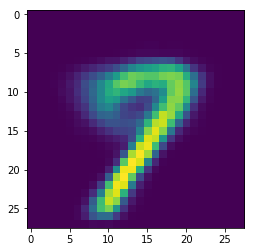

epoch finished :  12
149.90468 6.59064 156.49532


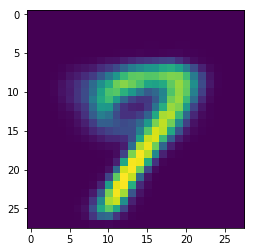

epoch finished :  13
154.79013 7.361412 162.15155


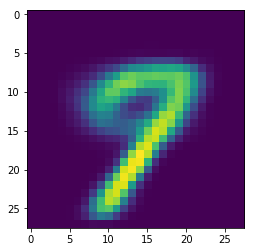

epoch finished :  14
156.16829 7.6478953 163.81618


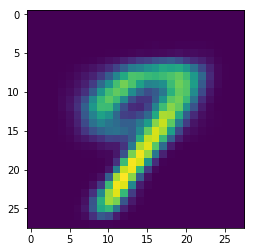

epoch finished :  15
146.27168 6.3272667 152.59895


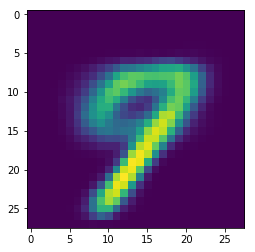

epoch finished :  16
147.66707 6.209321 153.87639


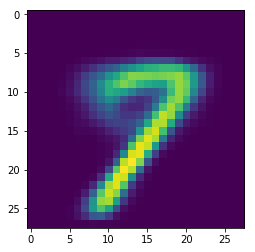

epoch finished :  17
142.3487 7.983357 150.33205


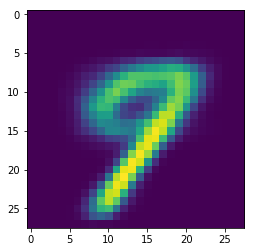

epoch finished :  18
138.22394 7.9299235 146.15385


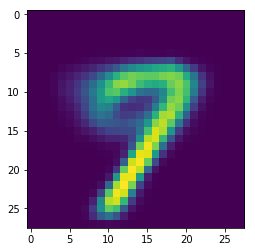

epoch finished :  19
148.60916 8.700684 157.30984


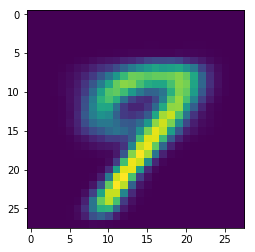

epoch finished :  20
145.53477 7.783944 153.31873


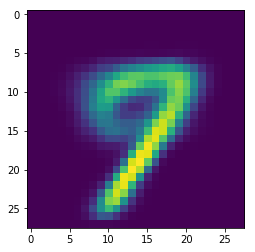

KeyboardInterrupt: 

In [279]:
for epoch in range(100):
    rces = []
    rges = []
    losses = []
    
    for idx, data in enumerate(train_loader):
        batch = data[0].to(device)
        rce, rge, loss = m_vae.train(batch)
        
        rces.append(rce)
        rges.append(rge)
        losses.append(loss)        
        
    
    print("epoch finished : ", epoch)
    print(np.mean(rce), np.mean(rge), np.mean(loss))

    ti = train_set[15][0].to(device)
    m, s=m_vae.encode(ti.view(1,1,28,28))
    z = m_vae.reparameterization(m,s)
    rm = m_vae.decode(z)
    plt.imshow(rm[0][0].detach().cpu().numpy())
    plt.show()
        
    
    

In [320]:
loss_r = np.array([
    [158.36618, 5.2586203, 163.6248],
[155.61815, 5.689371, 161.30753],
[150.13658, 5.9639697, 156.10056],
[147.65298, 6.1805015, 153.83348],
[142.32967, 6.79648, 149.12614],
[141.74341, 6.071129, 147.81454],
[149.34906, 6.8216224, 156.17068],
[147.86131, 7.1639123, 155.02522],
[134.87906, 7.710749, 142.58981],
[147.05203, 6.810031, 153.86206],
[148.3289, 7.7040434, 156.03294],
[142.00488, 7.737478, 149.74236],
[149.90468, 6.59064, 156.49532],
[154.79013, 7.361412, 162.15155],
[156.16829, 7.6478953, 163.81618],
[146.27168, 6.3272667, 152.59895],
[147.66707, 6.209321, 153.87639],
[142.3487, 7.983357, 150.33205],
[138.22394, 7.9299235, 146.15385],
[148.60916, 8.700684, 157.30984],
[145.53477, 7.783944, 153.31873]
])


In [321]:
recon_l = loss_r[:,0]
regul_l = loss_r[:,1]
tot_l = loss_r[:,2]

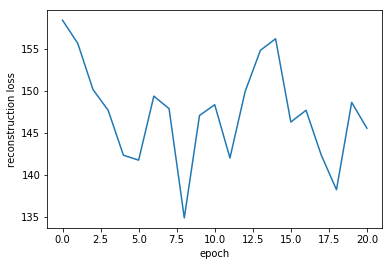

In [334]:
plt.plot(recon_l)
plt.xlabel("epoch")
plt.ylabel("reconstruction loss")
plt.savefig("recon_loss.png",dpi=100)
plt.show()

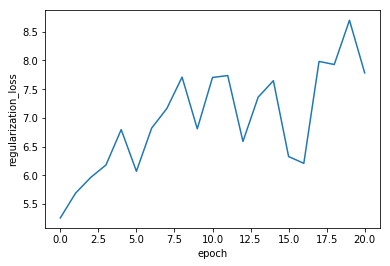

In [335]:
plt.plot(regul_l)
plt.xlabel("epoch")
plt.ylabel("regularization_loss")
plt.savefig("regul_loss.png",dpi=100)
plt.show()

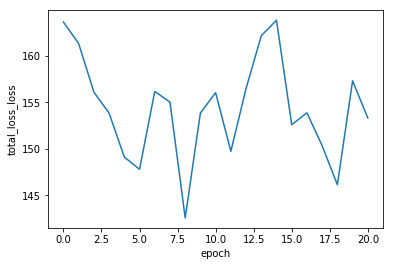

In [336]:
plt.plot(tot_l)
plt.xlabel("epoch")
plt.ylabel("total_loss_loss")
plt.savefig("total_loss.png",dpi=100)
plt.show()

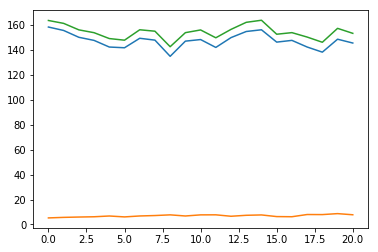

In [322]:
plt.plot(recon_l)
plt.plot(regul_l)
plt.plot(tot_l)